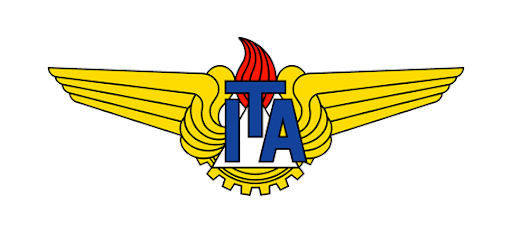
<!-- # Projeto 01 -->
<h1 style="color: black;
  font-size: 36px;
  text-align: center;">Lab 03</h1>
<h1 style="color: black;
  font-size: 30px;
  text-align: center;">CTC17-Inteligência Artificial</h1>
<h1 style="color: black;
  font-size: 18px;
  text-align: center;">Alunos:Pedro Alves de Souza Neto</h1>
<h1 style="color: black;
  font-size: 18px;
  text-align: center;">Professor: Paulo André Lima de Castro</h1>
<h1 style="color: black;
  font-size: 18px;
  text-align: center;">Assunto: Aprendizado de Máquina<br></h1>
<h5 style="
  font-size: 12px;
  text-align: center;">alvesouza.pedro97@gmail.com</h5>

# Linguagem utilizada
Foi o python, junto com o Jupyter.

<h1 style="color: black;
  font-size: 36px;">Primeiro Problema</h1>
  
<h1 style="color: black;
  font-size: 36px;">Arvores de decisão</h1>

Árvores de decisão são um modelo de aprendizado, onde uma estrutura de árvores é gerada, onde as suas conexões são usadas quando o valor do parâmetro testado possui valor correspondente, permitindo o percurso pela árvore.

# Importa bibliotecas

In [1]:
import pandas as pd
import math
import numpy as np
import random
random.seed(100)

# Divide a base de dados
    Seleciona a base de dados e a divide entre treino e teste. E seleciona os parametros para determinar o que usar para a geração da árvore.
    
    Divide entre o treino e teste entre 8:2.
    
    Os valores dos parâmetros são determinados retirando a ‘Data’, pois o valor da data é extremamente específico podendo prejudicar a precisão da árvore. Foi retirado o ‘Countries’, pois o ‘Local’ já determina o país e é muito mais significado.

In [2]:
    data_df = pd.read_csv("accident_data.csv")
    data_size = len(data_df)
    df_training, df_testing = \
        np.split(data_df.sample(frac=1, random_state=100),
                 [int(.8 * len(data_df))])

    parameters = ['Local', 'Industry Sector',
                  'Potential Accident Level', 'Genre', 'Employee ou Terceiro', 'Risco Critico']

# Função determina o melhor parâmetro, com a menor entropia

In [3]:
def give_us_best_entropy_param(data_frame=pd.DataFrame(), params=[], result=""):
    best_p = ""
    best_entropy = 0
    unchanged_entropy = True
    count_rows = data_frame[result].count()
    for p in params:
        if p != result:
            list_values = data_frame[p].unique()
            entropy = 0
            for value in list_values:
                dt = data_frame[(data_frame[p] == value)]
                value_counts = dt[result].value_counts()
                count = dt[result].count()

                for index in value_counts:
                    prob = index / count
                    if prob < 1 and prob > 0:
                        entropy -= (prob * math.log(prob, 2)) * (count / count_rows)
            if best_entropy > entropy or unchanged_entropy:
                best_entropy = entropy
                best_p = p
                unchanged_entropy = False
    return best_p, best_entropy

# Classe das conexões das árvores

    Classe que associa as conexões e poda a subárvore no final, caso a entropia não tenha melhorado.

In [4]:
class Connection_Sub_Tree(object):
    def __init__(self, value, entropy, data_frame, params, result, index=[0]):
        self.value = value

        self.sub_tree = Tree(data_frame, params, result, index)
        self.entropy = entropy
        if not self.sub_tree.leaf:
            if self.entropy > self.sub_tree.entropy:
                self.entropy = self.sub_tree.entropy
            else:
                self.sub_tree.leaf = True
                self.sub_tree.entropy = self.entropy
                self.sub_tree.sub_trees.clear()
        else:
            self.sub_tree.entropy = self.entropy

# Classe das árvores
    Classe que gera as árvores, onde no ‘__init__’ se determina qual é o parâmetro mais importante na determinação do parâmetro ótimo para gerar uma estimativa mais precisa.Ao determinar o valor das entropias das subárvores, eles são utilizados para calcular o valor da entropia da árvore.

In [5]:
class Tree(object):
    def __init__(self, data_frame, params, result, index=[0]):
        if isinstance(data_frame, pd.DataFrame):
            self.data_frame = data_frame
            self.number_rows = self.data_frame[result].count()
            self.leaf = False
            self.index = index[0]
            index[0] += 1
            if isinstance(params, list) and (all(isinstance(n, str) for n in params)):
                self.params = params
            else:
                raise TypeError("Error, param has to be a list of strings")
            if isinstance(result, str):
                self.result = result
            else:
                raise TypeError("Error, result has to be string")
            value_counts = data_frame[result].value_counts()
            self.expected_result = value_counts.idxmax()
            if len(self.params) > 0:
                self.param, self.entropy = give_us_best_entropy_param(self.data_frame, self.params, self.result)
                self.sub_trees = []
                parameters_sub = self.params.copy()
                parameters_sub.remove(self.param)
                values = data_frame[self.param].unique()
                for value in values:
                    self.sub_trees.append(
                        Connection_Sub_Tree(value, self.entropy,
                                            data_frame[
                                                data_frame[self.param] == value
                                                ],
                                            parameters_sub,
                                            result,
                                            index
                                            )
                    )
                self.entropy = 0
                for sub in self.sub_trees:
                    self.entropy += sub.sub_tree.number_rows * sub.entropy / self.number_rows
            else:
                self.leaf = True

        else:
            raise TypeError("Error, error data_frame has to be a pandas' DataFrame")

    #Estima o valor dos resultados no caso é do "Accident Level"
    def estimate_results(self, data, list_choices=['I', 'II', 'III', 'IV', 'V']):
        if isinstance(data, pd.DataFrame):
            estimated = "estimated_result"
            data[estimated] = "0"
            # print(data)
            number_entries = data["estimated_result"].count()
            index_list = data.index
            i = 0
            while i < number_entries:
                data.loc[index_list[i], estimated] = \
                    self.calculate_estimation(data.iloc[[i]], self)
                i += 1

            i = 0

            n_list = len(list_choices)
            matrix = []
            precise_estimations = 0
            while i < n_list:
                j = 0
                matrix.append([])
                while j < n_list:
                    quant = data[(data[estimated] == list_choices[i]) &
                                 (data[self.result] == list_choices[j])][
                        self.result].count()
                    if i == j:
                        precise_estimations += quant
                    matrix[i].append(quant)
                    j += 1
                i += 1

            return pd.DataFrame(matrix, index=list_choices, columns=list_choices), precise_estimations, number_entries
        else:
            raise TypeError("Error, error data_frame has to be a pandas' DataFrame")

    #Estima o valor de uma linha dos dados
    def calculate_estimation(self, data, tree_go):
        if isinstance(data, pd.DataFrame):
            if isinstance(tree_go, Tree):
                for sub in tree_go.sub_trees:
                    if data[tree_go.param].values[0] == sub.value:
                        # found = True
                        resultado = self.calculate_estimation(data, sub.sub_tree)
                        return resultado
                resultado = tree_go.expected_result
                return resultado

# Divide os dados
    Divide os dados entre os de treino(80%) e teste(20%).

In [6]:
df_training, df_testing = \
                  np.split(data_df.sample(frac=1, random_state=42),
                           [int(.8*len(data_df))])

In [7]:
df_training

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico
265,2016-11-11 00:00:00,Country_01,Local_06,Metals,IV,IV,Male,Employee,Others
78,2016-03-22 00:00:00,Country_01,Local_03,Mining,I,II,Male,Employee,Others
347,2017-02-17 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Projection
255,2016-10-20 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,Pressurized Systems
327,2017-02-01 00:00:00,Country_03,Local_10,Others,I,II,Male,Third Party,Projection/Choco
...,...,...,...,...,...,...,...,...,...
216,2016-08-30 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Others
279,2016-12-08 00:00:00,Country_01,Local_01,Mining,I,III,Male,Third Party (Remote),Others
380,2017-04-06 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Others
337,2017-02-09 00:00:00,Country_01,Local_03,Mining,IV,V,Male,Third Party (Remote),Power lock


In [8]:
df_training["Accident Level"].value_counts()

I      261
II      32
III     27
IV      23
V        8
Name: Accident Level, dtype: int64

In [9]:
df_testing

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico
207,2016-08-18 00:00:00,Country_01,Local_03,Mining,I,III,Male,Employee,Others
212,2016-08-24 00:00:00,Country_01,Local_01,Mining,I,II,Male,Employee,Others
295,2016-12-26 00:00:00,Country_01,Local_06,Metals,I,II,Male,Employee,Others
400,2017-05-06 00:00:00,Country_01,Local_01,Mining,III,IV,Male,Third Party,Manual Tools
251,2016-10-13 00:00:00,Country_02,Local_02,Mining,II,II,Male,Third Party (Remote),Others
...,...,...,...,...,...,...,...,...,...
106,2016-04-17 00:00:00,Country_02,Local_05,Metals,I,IV,Male,Employee,Cut
270,2016-11-23 00:00:00,Country_01,Local_04,Mining,I,II,Male,Employee,Others
348,2017-02-23 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Vehicles and Mobile Equipment
435,2017-07-04 00:00:00,Country_01,Local_03,Mining,I,II,Female,Employee,Others


In [10]:
df_testing["Accident Level"].value_counts()

I      67
II      8
IV      8
III     4
V       1
Name: Accident Level, dtype: int64

# Cria as árvores
    Baseado pelos dados de teste

In [11]:
parameters = [ 'Local', 'Industry Sector',
               'Potential Accident Level', 'Genre', 'Employee ou Terceiro', 'Risco Critico']

result = "Accident Level"
tree = Tree(df_training, parameters, result, [0])

# Importa as bibliotecas para desenhar grafos

In [12]:
import pydot
import os

# Função para criação dos grafos
    Cria o grafo da árvore, onde a raiz é verde, o azul claro é para as folhas.

    Onde os nós são composto por índice(Os textos precisam ser diferentes para cada nó), o parâmetro de decisão, a entropia e o resultado mais provável até chegar ao nó e essa será a resposta caso não passe para a próxima subárvore.

In [13]:
G = pydot.Dot()
G.set_node_defaults(
                    style='filled',
                    shape='box',
                    fontsize='10')
def create_tree_graph(tree_graph, graph):
    if isinstance(tree_graph, Tree):
        if isinstance(graph, pydot.Dot):
            # stack_tree = [tree]
            # stack_graph = []
            if tree_graph.index == 0:
                color = "green"
            elif tree_graph.leaf:
                color = "lightblue"
            else:
                color = "yellow"
            string1 = "{:^15}\n{}\n{:06.5f}\n{}".format(
                    tree_graph.index,
                    tree_graph.param,
                    tree_graph.entropy,
                    tree_graph.expected_result
                    )
            node = pydot.Node(string1, fillcolor=color)
            graph.add_node(node)

            for sub in tree_graph.sub_trees:
                if sub.sub_tree.index == 0:
                    color = "green"
                elif sub.sub_tree.leaf:
                    color = "lightblue"
                else:
                    color = "yellow"
                
                string2 = "{:^15}\n{}\n{:06.5f}\n{}".format(
                    sub.sub_tree.index,
                    sub.sub_tree.param,
                    sub.sub_tree.entropy,
                    sub.sub_tree.expected_result
                )
                node = pydot.Node(string2, fillcolor=color)
                graph.add_node(node)
                edge = pydot.Edge(string1, string2, label=str(sub.value))
                graph.add_edge(edge)
                graph = create_tree_graph(sub.sub_tree, graph)

            return graph
        else:
            raise TypeError("'graph has to be 'pydot.Dot' object")

    else:
        raise TypeError("'create_tree_graph has to receive 'Tree' object!")

G = create_tree_graph(tree, G)


# Cria grafo resultante

caso a imagem não seja visivel pelo pdf, pode utilizar o jupyter ou acessar o link [imagem da árvore](https://drive.google.com/file/d/1sfqTG9a7hIprUiO4QM63zQtFZlBGY9Fh/view?usp=sharing)

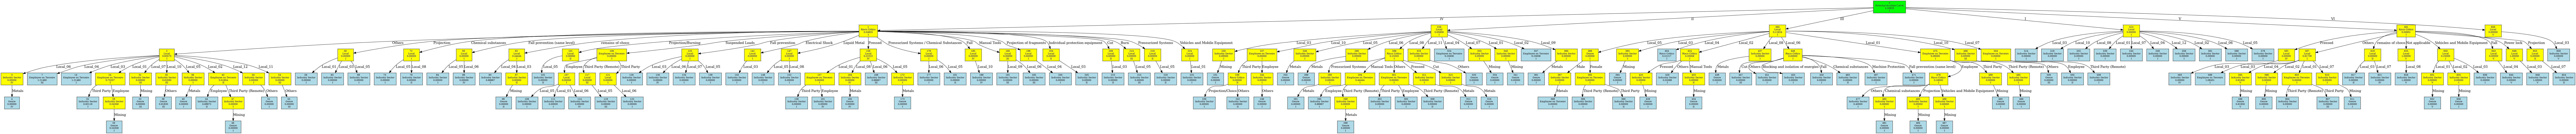

In [14]:
from IPython.display import Image, display, HTML
im = Image(G.create_png())
display(im)

# Função que gera os acertos gerados de forma aleatória

In [15]:
def random_correct_guess(data, list_choices=['I', 'II', 'III', 'IV', 'V']):
    if isinstance(data, pd.DataFrame):
        number_entries = len(data)
        number_possibilities = len(list_choices)
        i = 0
        precise_estimations = 0
        index_data = data.index
        while i < number_entries:
            rand = random.randrange(0, number_possibilities)
            if data["Accident Level"][index_data[i]] == list_choices[rand]:
                precise_estimations += 1
            i += 1

        return precise_estimations, number_entries
    else:
        raise TypeError("Error, error data_frame has to be a pandas' DataFrame")

# Demostração do resultado, com os dados de treino.

Matriz de confusão

In [16]:
matrix, precise_estimations, number_entries = tree.estimate_results(df_training)
matrix

,I,II,III,IV,V
I,259,12,8,7,1
II,0,18,1,0,0
III,2,2,18,4,0
IV,0,0,0,9,0
V,0,0,0,3,7


Acertos

In [17]:
precise_estimations

311

In [18]:
number_entries

351

Taxa de acerto

In [19]:
precise_estimations / number_entries

0.886039886039886

 Mesmo sendo os mesmos dados de treino, o resultado é diferente, pois mesmo que os parâmetros possuam os mesmos valores, devido ao fato de se selecionar o mais frequente durante o treino, deixando uma fração de fora.

# Estima o resultado para os casos de teste

In [20]:
matrix, precise_estimations, number_entries = tree.estimate_results(df_testing)

- Matriz de confusão

In [21]:
matrix

,I,II,III,IV,V
I,60,6,2,6,0
II,3,0,0,1,0
III,3,2,1,0,0
IV,1,0,1,1,0
V,0,0,0,0,1


- Gera proporção de acertos.

In [22]:
p_tree = precise_estimations / number_entries
p_tree

0.7159090909090909

- Gera a probabilidade aleatoriamente.

In [23]:
precise_estimations_random, number_entries = random_correct_guess(data=df_testing)
p_random = precise_estimations_random / number_entries
p_random

0.20454545454545456

- Coeficiente de Kappa.

In [24]:
kappa = (p_tree - p_random)/(1-p_random)
kappa

0.6428571428571429

# Classificador a priori

Classificador a priori pega o valor mais frequente para determinar o valor esperado.

In [25]:
class AprioriModel(object):
    def __init__(self, training_model, result = "Accident Level"):
        if isinstance(training_model, pd.DataFrame):
            self.result = result
            self.expected_result = training_model[self.result].value_counts().idxmax()

    def estimate_results(self, data, list_choices=['I', 'II', 'III', 'IV', 'V']):
        if isinstance(data, pd.DataFrame):
            estimated = "estimated_result"
            number_entries = len(data)
            index_list = data.index

            i = 0

            n_list = len(list_choices)
            matrix = []
            precise_estimations = 0
            while i < n_list:
                j = 0
                matrix.append([])
                while j < n_list:
                    quant = data[(data[self.result] == list_choices[i]) &
                                 (self.expected_result == list_choices[j])][
                        self.result].count()
                    if i == j:
                        precise_estimations += quant
                    matrix[i].append(quant)
                    j += 1
                i += 1
            return pd.DataFrame(matrix, index=list_choices, columns=list_choices), precise_estimations, number_entries
        else:
            raise TypeError("Error, error data_frame has to be a pandas' DataFrame")
            
apriori = AprioriModel(df_training)

# Estima os resultados usando o classificador a priori

In [26]:
matrix_apriori, precise_estimations_apriori, number_entris_apriori = apriori.estimate_results(df_testing)

- Matriz de confusão

In [27]:
matrix_apriori

,I,II,III,IV,V
I,67,0,0,0,0
II,8,0,0,0,0
III,4,0,0,0,0
IV,8,0,0,0,0
V,1,0,0,0,0


- Gera proporção de acertos.

In [28]:
p_apriori = precise_estimations_apriori / number_entris_apriori
p_apriori

0.7613636363636364

- Coeficiente de Kappa.

In [29]:
kappa = (p_tree - p_random)/(1-p_random)
kappa

0.6428571428571429


# Conclusão
Usar o algoritmo de árvore é bem preciso, o problema dela é que quando não se tem parâmetros suficientes, na hora de se determinar um nó da árvore ele vai determinar o mais provável, fazendo ignorar os outros causando os erros.

Devido à concentração de acidentes de level ‘I’, faz o classificador a priori ser bastante preciso, até mais que a árvore.

O fato de se ignorar os outros possíveis resultados na árvore, ele causa um erro acumulado, quando se passa por uma tabela. Ou seja para melhorar as estimativas dos acidentes, nos nós poderia se utilizar a probabilidade de cada resultado, assim ao se estimar os acidentes teríamos os valores esperados, garantindo maior precisão no total. 